In [14]:
!pip install kaggle

In [15]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [16]:
!kaggle datasets download -d vigneshvenkateswaran/bot-iot-5-data

Dataset URL: https://www.kaggle.com/datasets/vigneshvenkateswaran/bot-iot-5-data
License(s): unknown
bot-iot-5-data.zip: Skipping, found more recently modified local copy (use --force to force download)


In [17]:
import zipfile

with zipfile.ZipFile('/content/bot-iot-5-data.zip', 'r') as zip_ref:
    zip_ref.extractall('dataset')

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
import networkx as nx

df = pd.read_csv('/content/dataset/reduced_data_1.csv')

df['stime'] = pd.to_datetime(df['stime'], unit='s')
df.info()

<ipython-input-18-c36a35ce7e13>:8: DtypeWarning:

Columns (7,9) have mixed types. Specify dtype option on import or set low_memory=False.



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 46 columns):
 #   Column                            Non-Null Count    Dtype         
---  ------                            --------------    -----         
 0   pkSeqID                           1000000 non-null  int64         
 1   stime                             1000000 non-null  datetime64[ns]
 2   flgs                              1000000 non-null  object        
 3   flgs_number                       1000000 non-null  int64         
 4   proto                             1000000 non-null  object        
 5   proto_number                      1000000 non-null  int64         
 6   saddr                             1000000 non-null  object        
 7   sport                             1000000 non-null  object        
 8   daddr                             1000000 non-null  object        
 9   dport                             1000000 non-null  object        
 10  pkts               

In [19]:
!pip install plotly

In [20]:
import plotly.graph_objects as go

# Reduce dataset size for performance
df_sample = df.sample(n=10000, random_state=1)

# Ensure source and destination addresses are strings
df_sample['saddr'] = df_sample['saddr'].astype(str)
df_sample['daddr'] = df_sample['daddr'].astype(str)

# Select top 10 source and destination IPs
top_source_ips = df_sample['saddr'].value_counts().nlargest(10).index
top_dest_ips = df_sample['daddr'].value_counts().nlargest(10).index

# Filter dataset
df_filtered = df_sample[df_sample['saddr'].isin(top_source_ips) & df_sample['daddr'].isin(top_dest_ips)]

# Create labels for Sankey diagram
labels = list(top_source_ips) + list(top_dest_ips)

# Map IP addresses to their respective indices
source_indices = [labels.index(ip) for ip in df_filtered['saddr']]
dest_indices = [labels.index(ip) + len(top_source_ips) for ip in df_filtered['daddr']]

# Create the Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels,
    ),
    link=dict(
        source=source_indices,
        target=dest_indices,
        value=df_filtered['pkts']
    )
)])

fig.update_layout(title_text="Flow Analysis - Sankey Diagram", font_size=10)
fig.show()


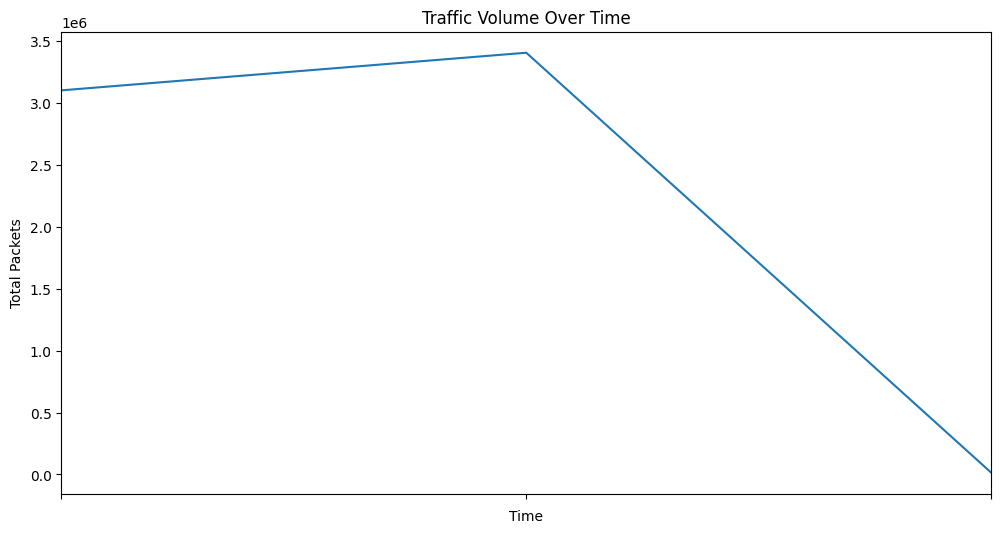

In [21]:
traffic_volume = df.set_index('stime').resample('H')['pkts'].sum()

plt.figure(figsize=(12, 6))
traffic_volume.plot()
plt.title('Traffic Volume Over Time')
plt.xlabel('Time')
plt.ylabel('Total Packets')
plt.show()


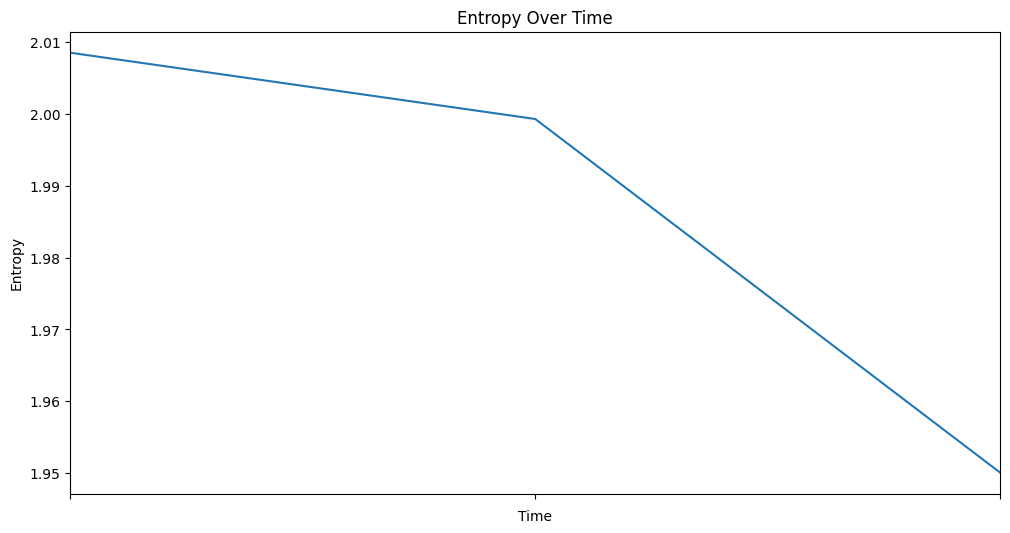

In [22]:
from scipy.stats import entropy

# Calculate entropy over time
df['hour'] = df['stime'].dt.floor('H')
entropy_df = df.groupby('hour').apply(lambda x: entropy(x['saddr'].value_counts(), base=2))

plt.figure(figsize=(12, 6))
entropy_df.plot()
plt.title('Entropy Over Time')
plt.xlabel('Time')
plt.ylabel('Entropy')
plt.show()


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 47 columns):
 #   Column                            Non-Null Count    Dtype         
---  ------                            --------------    -----         
 0   pkSeqID                           1000000 non-null  int64         
 1   stime                             1000000 non-null  datetime64[ns]
 2   flgs                              1000000 non-null  object        
 3   flgs_number                       1000000 non-null  int64         
 4   proto                             1000000 non-null  object        
 5   proto_number                      1000000 non-null  int64         
 6   saddr                             1000000 non-null  object        
 7   sport                             1000000 non-null  object        
 8   daddr                             1000000 non-null  object        
 9   dport                             1000000 non-null  object        
 10  pkts               

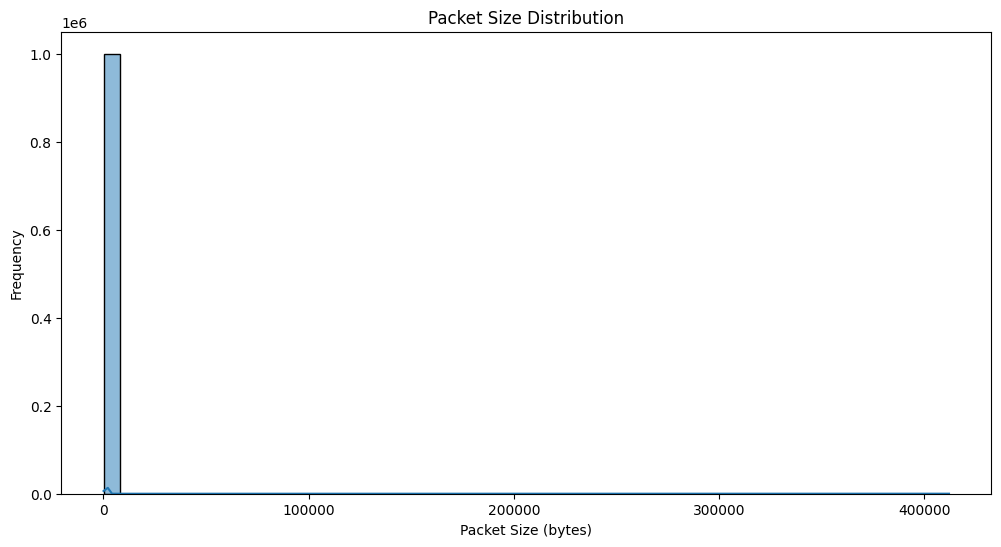

In [24]:
plt.figure(figsize=(12, 6))
sns.histplot(df['bytes'], bins=50, kde=True)
plt.title('Packet Size Distribution')
plt.xlabel('Packet Size (bytes)')
plt.ylabel('Frequency')
plt.show()


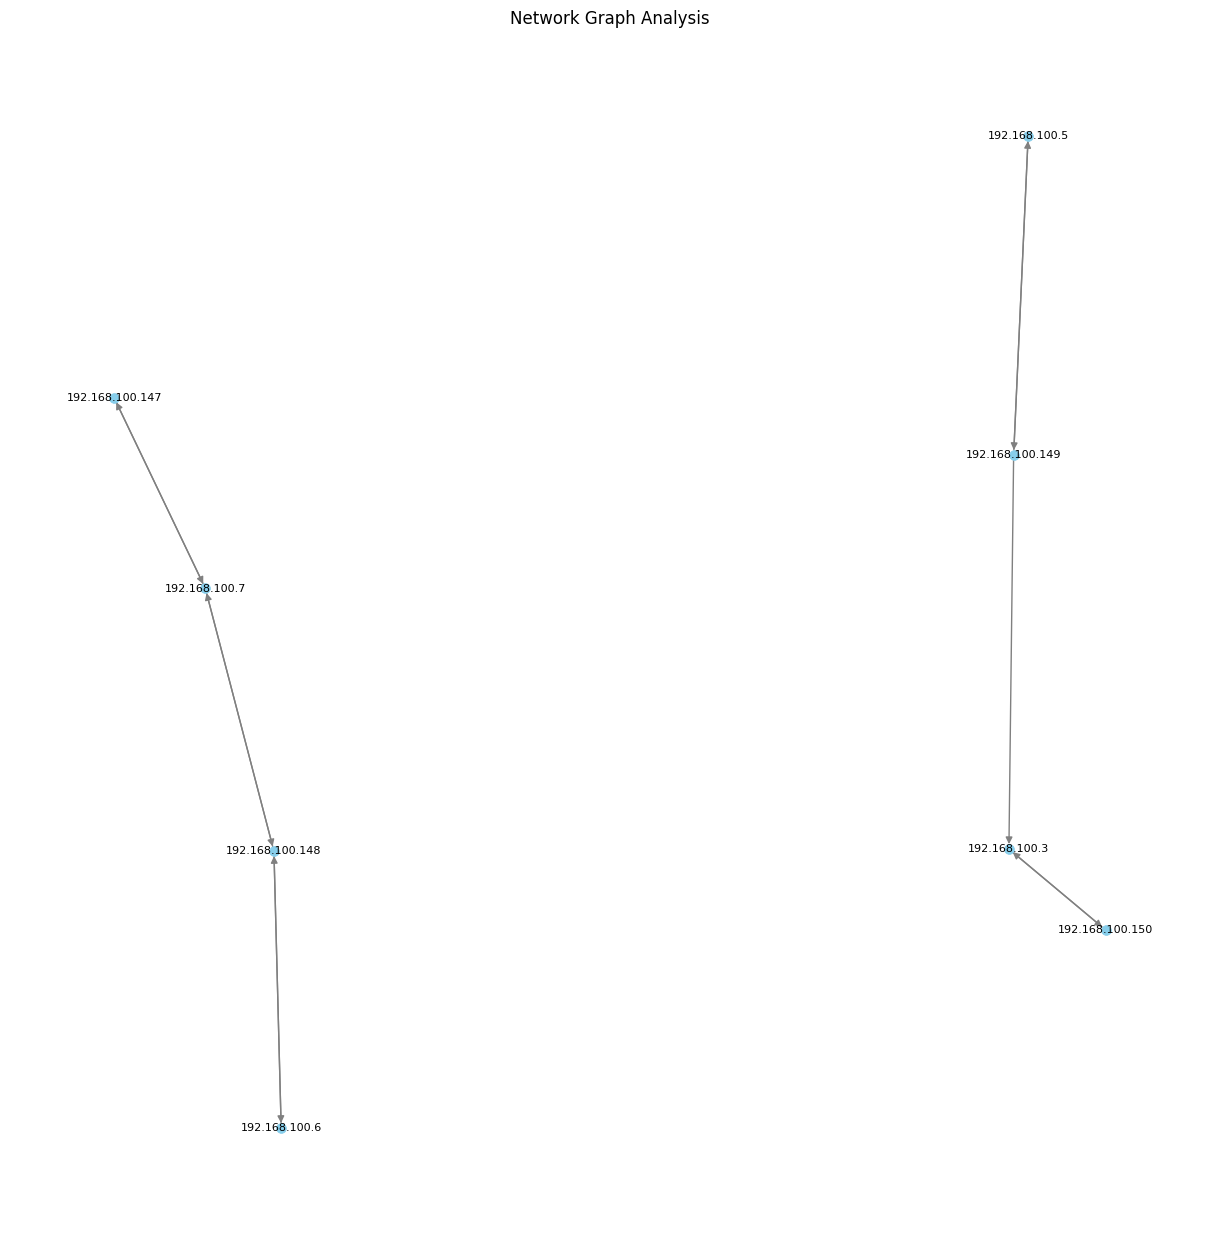

In [25]:
G = nx.from_pandas_edgelist(df, 'saddr', 'daddr', create_using=nx.DiGraph)

plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.1)
nx.draw(G, pos, with_labels=True, node_size=50, node_color='skyblue', edge_color='gray', linewidths=0.5, font_size=8)
plt.title('Network Graph Analysis')
plt.show()


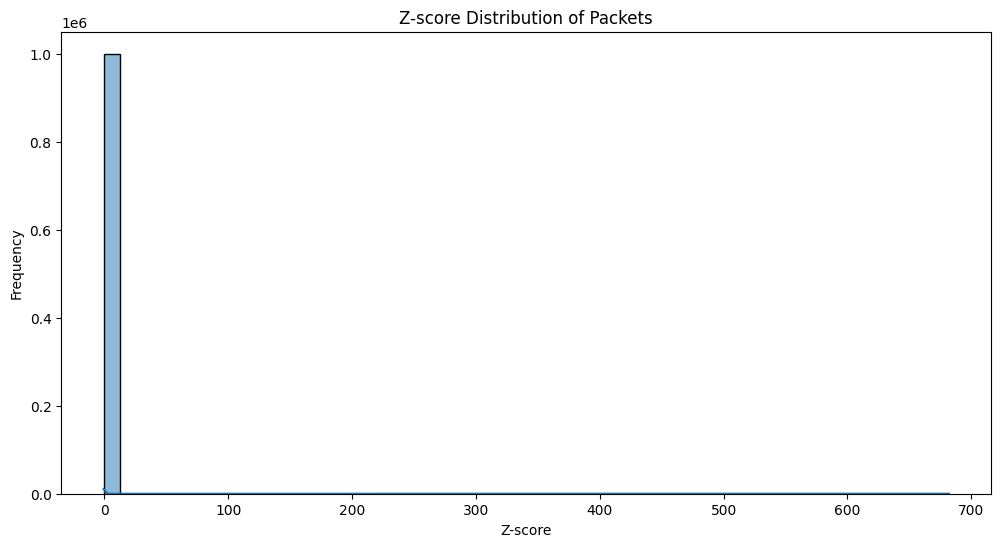

In [26]:
# Calculate z-scores for the number of packets
df['pkts_zscore'] = zscore(df['pkts'])

plt.figure(figsize=(12, 6))
sns.histplot(df['pkts_zscore'], bins=50, kde=True)
plt.title('Z-score Distribution of Packets')
plt.xlabel('Z-score')
plt.ylabel('Frequency')
plt.show()
